# The goal of the project is to find the health insurance cost incured by Individuals based on thier age, gender, BMI, number of children, smoking habit and geo-location using multiple linear regression


IMPORT LIBRARIES

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# read the csv file 
insurance_df = pd.read_csv('insurance.csv')

In [17]:
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [18]:
# check if there are any Null
insurance_df.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

In [19]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [20]:
insurance_df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [21]:
# convert categorical variable to numerical
insurance_df['sex'].replace(['male', 'female'],[1, 0], inplace=True)
insurance_df['smoker'].replace(['yes', 'no'],[1, 0], inplace=True)
insurance_df['region'].replace(['southwest', 'southeast', 'northwest', 'northeast'],[3,2,1, 0], inplace=True)
insurance_df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


VISUALIZE DATASET

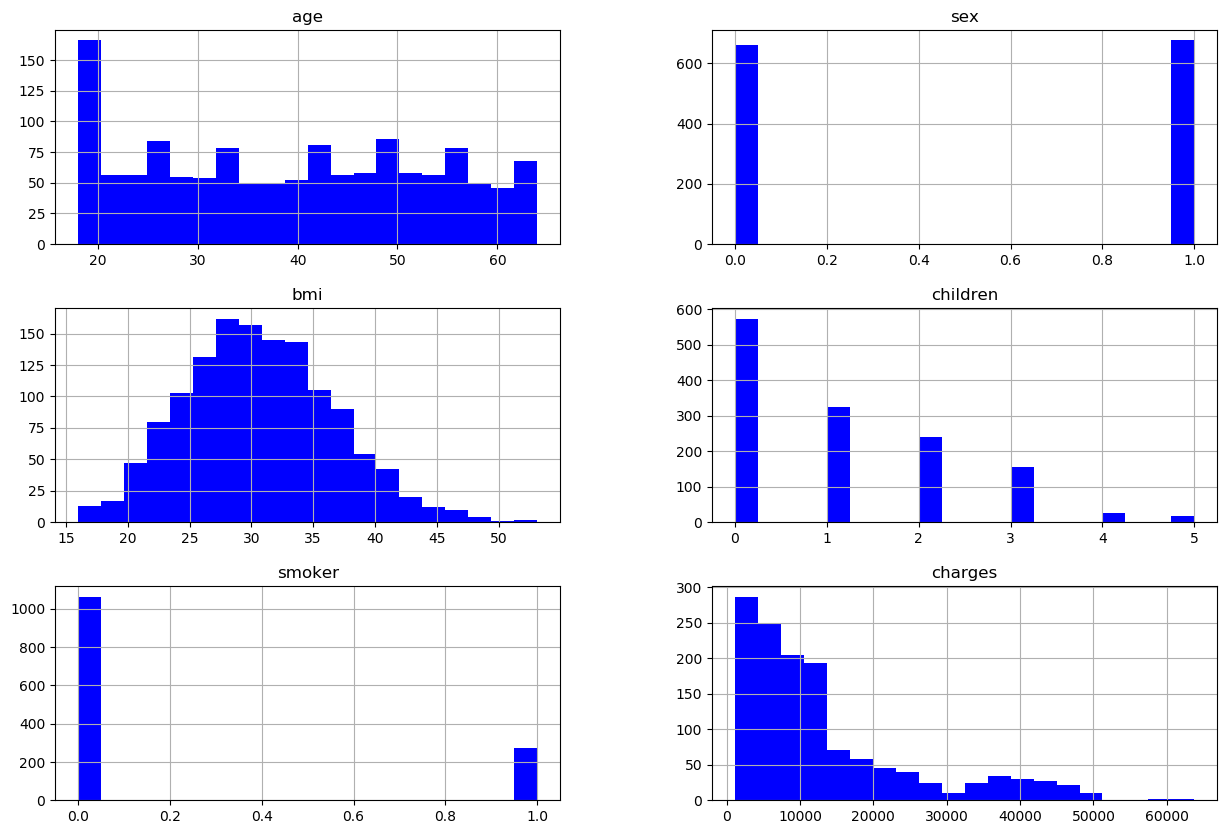

In [22]:
insurance_df[['age', 'sex', 'bmi', 'children', 'smoker', 'charges']].hist(bins = 20, figsize = (15,10), color = 'b')
plt.show()

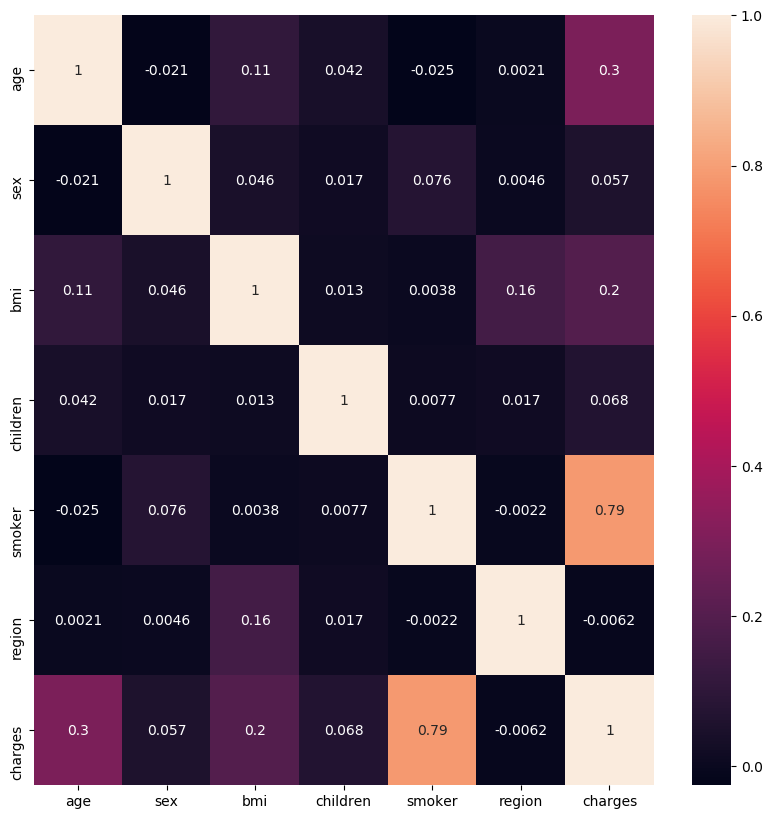

In [23]:
plt.figure(figsize = (10,10))
sns.heatmap(insurance_df.corr(), annot = True)
plt.show()

CREATE TRAINING AND TESTING DATASET

We want to predict charges, so charge is dependent variable and others are features(independent variable)

In [24]:
X = insurance_df.drop(columns =['charges'])
y = insurance_df['charges']

In [25]:
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [26]:
y = y.reshape(-1,1)
y.shape

(1338, 1)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
#preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

# TRAIN THE MODEL

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
regresssion_model_sklearn = LinearRegression()
regresssion_model_sklearn.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
#Prediction
y_predict = regresssion_model_sklearn.predict(X_test)

In [31]:
#Evaluation
accuracy = regresssion_model_sklearn.score(X_test, y_test)
accuracy

0.7844132921177845

In [32]:
from sklearn.metrics import r2_score, mean_absolute_error

MSE = mean_absolute_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

In [33]:
print('MSE =',MSE,'\nR2 =', r2) 

MSE = 0.3248758 
R2 = 0.7844132921177845


# TRAIN THE MODEL USING SAGEMAKER

In [34]:
#Boto3 is a Software Development Kit (SDK) for Python

import sagemaker
import boto3
from sagemaker import Session
#create a Sagemaker session
sagemaker_session = sagemaker.Session()
bucket = 'sagemaker--project'
prefix = 'poly_linear_learner' #subfolder in bucket
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::328532437175:role/service-role/AmazonSageMaker-ExecutionRole-20230427T180526


In [35]:
y_train = y_train[:,0]

In [36]:
y_train.shape

(1070,)

In [37]:
import io 
import numpy as np
import sagemaker.amazon.common as smac 
# convert the data from numpy array format to RecordIO format
buf = io.BytesIO() 
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0) #reset the counter, it increments 1 every time you write to it

0

In [38]:
import os
# The data in record-io format to S3 bucket to be accessed later for training
key = 'linear-train-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker--project/poly_linear_learner/train/linear-train-data


In [39]:
y_test = y_test[:,0]
buf = io.BytesIO() 
smac.write_numpy_to_dense_tensor(buf, X_test, y_test)
buf.seek(0) 

0

In [40]:
key = 'linear-test-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_test_data))

uploaded training data location: s3://sagemaker--project/poly_linear_learner/test/linear-test-data


In [41]:
#store the linear learner output
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://sagemaker--project/poly_linear_learner/output


In [42]:
#get the training container of sagemaker built-in algorithms
from sagemaker.amazon.amazon_estimator import get_image_uri 
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [43]:
#pass in the container, the type of instance,output path
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count = 1, 
                                       train_instance_type = 'ml.c4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session,
                                       train_use_spot_instances = True,
                                       train_max_run = 300,
                                       train_max_wait = 600)
#Tune hyper parameters
linear.set_hyperparameters(feature_dim = 6,
                           predictor_type = 'regressor',
                           mini_batch_size = 4,
                           epochs = 100,
                           num_models = 32,
                           loss = 'absolute_loss')

linear.fit({'train': s3_train_data})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: linear-learner-2023-05-03-02-34-58-020


2023-05-03 02:34:58 Starting - Starting the training job...
2023-05-03 02:35:38 Starting - Preparing the instances for training............
2023-05-03 02:37:17 Downloading - Downloading input data...
2023-05-03 02:37:42 Training - Downloading the training image......
2023-05-03 02:39:08 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/03/2023 02:39:14 INFO 140486270605120] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'l

# DEPLOY THE MODEL 

In [44]:
linear_regressor = linear.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2023-05-03-02-42-23-102
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-05-03-02-42-23-102
INFO:sagemaker:Creating endpoint with name linear-learner-2023-05-03-02-42-23-102


-------!

In [45]:
from sagemaker.predictor import csv_serializer, json_deserializer
# Content type overrides the data that will be passed to the deployed model, since the deployed model expects data in text/csv format.
linear_regressor.serializer = csv_serializer
linear_regressor.deserializer = json_deserializer

In [46]:
result = linear_regressor.predict(X_test)
predictions = np.array([r['score'] for r in result['predictions']])
predictions

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


array([-0.29972306, -0.56643319,  2.64945674, -0.30147588,  1.6470871 ,
       -0.60989249, -0.96569657,  0.0373286 , -0.76671165, -0.22504044,
        1.91620064, -0.42605704, -0.70939779,  2.35366631,  2.55491567,
        2.32978511, -0.19080012,  2.32544231, -0.3434951 ,  2.1904428 ,
       -0.74404293, -0.4179998 , -1.01702523, -0.81481653, -0.16794604,
       -0.14164583, -0.06618118, -0.66226631, -0.25075158, -1.01830602,
       -0.39208192, -0.10076189, -0.89794803, -0.63523549, -0.83233392,
       -0.34942597, -0.91756189, -0.42378116,  2.41016388,  2.04239321,
       -0.82051587, -0.87171412, -0.11786872, -0.11786117, -0.60342383,
       -0.12024705, -0.8146618 , -0.77155232,  2.26456141, -0.63740236,
        0.02535413, -0.987984  , -0.40379354, -0.99004263, -0.17188656,
       -0.20219462, -0.73020166,  2.01797652, -0.11727336, -0.16140133,
       -0.01277912, -0.60447562,  0.0215116 , -0.38753319, -0.19201882,
       -0.72320044,  1.75743711, -0.18944916, -0.80138785, -0.91

In [47]:
from sklearn.metrics import r2_score, mean_absolute_error

MSE = mean_squared_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

print('MSE =',MSE,'\nR2 =', r2) 

MSE = 0.2155867 
R2 = 0.7844132921177845


In [48]:
# Delete the end-point
linear_regressor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2023-05-03-02-42-23-102
INFO:sagemaker:Deleting endpoint with name: linear-learner-2023-05-03-02-42-23-102
